# Advanced Evaluation of Quantized Vectors: Cohere, MongoDB, and BEIR Integration

## What to Expect

In this notebook, we will conduct an advanced evaluation of quantized vectors using Cohere's embedding models, MongoDB for vector storage and search, and the BEIR (Benchmarking IR) framework for performance assessment. Here's what you can expect to learn and explore:

1. **Vector Quantization**: Understand the process and benefits of vector quantization in the context of embedding storage and retrieval.

2. **Cohere Integration**: Learn how to generate embeddings using Cohere's state-of-the-art models, including both float32 and quantized int8 versions.

3. **MongoDB Vector Storage**: Explore efficient ways to store and index vector embeddings in MongoDB, including BSON encoding for optimized storage.

4. **Vector Search Implementation**: Implement and compare vector search capabilities using different vector representations (float32, BSON float32, and BSON int8).

5. **BEIR Framework Usage**: Utilize the BEIR framework to evaluate the performance of our vector search implementations across various information retrieval metrics.

6. **Performance Comparison**: Analyze and visualize the performance differences between non-quantized and quantized vector representations in terms of:
   - Storage efficiency
   - Search accuracy

7. **Advanced Metrics**: Dive deep into advanced IR metrics such as NDCG, MAP, Recall, and Precision at different cut-off points.

8. **Visualization**: Create informative plots to compare the performance of different vector representations across multiple metrics.

9. **Practical Insights**: Gain insights into the trade-offs between storage efficiency and search performance, helping you make informed decisions for your own vector search applications.

By the end of this notebook, you will have a comprehensive understanding of how vector quantization affects the performance of embedding-based search systems, and you'll be equipped with the knowledge to implement and evaluate such systems using industry-standard tools and frameworks.

In [ ]:
%pip install git+https://github.com/caseyclements/mongo-python-driver.git@DRIVERS-2926-BSON-Binary-Vectors

In [ ]:
!pip install beir pandas cohere #pymongo

# **Step 1: Load the BEIR scifact dataset**

In [52]:
from beir import util, LoggingHandler
from beir.datasets.data_loader import GenericDataLoader
from beir.retrieval.evaluation import EvaluateRetrieval
import pandas as pd

# Load BEIR dataset
def load_beir_dataset(dataset_name="scifact"):
    url = f"https://public.ukp.informatik.tu-darmstadt.de/thakur/BEIR/datasets/{dataset_name}.zip"
    data_path = util.download_and_unzip(url, "datasets")
    corpus, queries, qrels = GenericDataLoader(data_folder=data_path).load(split="test")
    return corpus, queries, qrels

In [53]:
DATASET = "scifact"
corpus, queries, qrels = load_beir_dataset("scifact")

  0%|          | 0/5183 [00:00<?, ?it/s]

In [54]:
# print the first item in the corpus
print(list(corpus.items())[0])
print()
# print the first item in the queries
print(list(queries.items())[0])
print()
# print the first item in the qrels
print(list(qrels.items())[0])

('4983', {'text': 'Alterations of the architecture of cerebral white matter in the developing human brain can affect cortical development and result in functional disabilities. A line scan diffusion-weighted magnetic resonance imaging (MRI) sequence with diffusion tensor analysis was applied to measure the apparent diffusion coefficient, to calculate relative anisotropy, and to delineate three-dimensional fiber architecture in cerebral white matter in preterm (n = 17) and full-term infants (n = 7). To assess effects of prematurity on cerebral white matter development, early gestation preterm infants (n = 10) were studied a second time at term. In the central white matter the mean apparent diffusion coefficient at 28 wk was high, 1.8 microm2/ms, and decreased toward term to 1.2 microm2/ms. In the posterior limb of the internal capsule, the mean apparent diffusion coefficients at both times were similar (1.2 versus 1.1 microm2/ms). Relative anisotropy was higher the closer birth was to t

Corpus:
The corpus is a dictionary where each key is a document ID, and the value is another dictionary containing the document's text and title. For example:

```
'4983': {
    'text': 'Alterations of the architecture of cerebral white matter...',
    'title': 'Microstructural development of human newborn cerebral white matter...'
}
```


This corresponds to the scientific abstracts in our earlier example.

Queries:
The queries dictionary contains the scientific claims, where the key is a query ID and the value is the claim text. For example:

```
'1': '0-dimensional biomaterials show inductive properties.'
```

Qrels:
The qrels (query relevance) dictionary contains the ground truth relevance judgments. It's structured as a nested dictionary where the outer key is the query ID, the inner key is a document ID, and the value is the relevance score (typically 1 for relevant, 0 for non-relevant). For example:

```
'1': {'31715818': 1}
```
This indicates that for query '1', the document with ID '31715818' is relevant.

In [55]:
# Convert the corpus to a dataframe
corpus_df = pd.DataFrame.from_dict(corpus, orient="index")

# Create coloumns for various embedding data types
corpus_df["float32_embedding"] = None
corpus_df["int8_embedding"] = None
corpus_df["bson_int8_embedding"] = None
corpus_df["bson_float32_embedding"] = None

In [56]:
corpus_df.head()

,text,title,float32_embedding,int8_embedding,bson_int8_embedding,bson_float32_embedding
4983,Alterations of the architecture of cerebral wh...,Microstructural development of human newborn c...,None,None,None,None
5836,Myelodysplastic syndromes (MDS) are age-depend...,Induction of myelodysplasia by myeloid-derived...,None,None,None,None
7912,ID elements are short interspersed elements (S...,"BC1 RNA, the transcript from a master gene for...",None,None,None,None
18670,DNA methylation plays an important role in bio...,The DNA Methylome of Human Peripheral Blood Mo...,None,None,None,None
19238,Two human Golli (for gene expressed in the oli...,The human myelin basic protein gene is include...,None,None,None,None


# **Step 2: Generate embedddings for float 32, Int8 embedding by using Cohere**

In [57]:
import os
import cohere
import getpass

# You are going to need a production API key due to rate limiting on free tier
COHERE_API_KEY = getpass.getpass("Enter Cohere API Key: ")
os.environ["COHERE_API_KEY"] = COHERE_API_KEY

Enter Cohere API Key: ··········


In [58]:
import cohere

# Initialize Cohere Client
co = cohere.Client(COHERE_API_KEY)

In [59]:
from typing import List, Tuple

def get_cohere_embeddings(sentences: List[str]) -> Tuple[List[float], List[int]]:
  """
  Generates embeddings for the provided sentences using Cohere's embedding model.

  Args:
      sentences (list of str): List of sentences to generate embeddings for.

  Returns:
    list: A list of embeddings, where each embedding corresponds to a sentence.
          The embeddings are generated using the "embed-english-v3.0" model and include both
          float and int8 types.
  """
  genereated_embedding = co.embed(
      texts=sentences,
      model="embed-english-v3.0",
      input_type="search_document",
      embedding_types=["float", "int8"]
  ).embeddings

  return genereated_embedding.float, genereated_embedding.int8

In [60]:
from tqdm import tqdm

# Create a tqdm progress bar
total_rows = len(corpus_df)
with tqdm(total=total_rows, desc="Generating embeddings") as pbar:
  # Iterate through each row in the DataFrame
  for index, row in corpus_df.iterrows():
    # Concatenate the title and text field and then use this data point for embedding generation
    concatenated_text = row["title"] + " " + row["text"]

    # Fetch the embeddings for the sentence
    embeddings = get_cohere_embeddings([concatenated_text])

    # Assign the embeddings to the corresponding columns in the DataFrame
    corpus_df.at[index, "float32_embedding"] = embeddings[0][0]  # float32_embedding
    corpus_df.at[index, "int8_embedding"] = embeddings[1][0]  # int8_embedding

    # Update the progress bar
    pbar.update(1)

Generating embeddings: 100%|██████████| 5183/5183 [22:16<00:00,  3.88it/s]


In [61]:
corpus_df.head()

,text,title,float32_embedding,int8_embedding,bson_int8_embedding,bson_float32_embedding
4983,Alterations of the architecture of cerebral wh...,Microstructural development of human newborn c...,"[-0.01966858, -0.021835327, -0.0135269165, 0.0...","[-25, -28, -17, 38, -52, -28, -9, -33, 17, 29,...",None,None
5836,Myelodysplastic syndromes (MDS) are age-depend...,Induction of myelodysplasia by myeloid-derived...,"[0.03463745, 0.018798828, -0.043823242, -0.074...","[43, 23, -56, -96, 21, -8, -20, -2, 6, 51, 39,...",None,None
7912,ID elements are short interspersed elements (S...,"BC1 RNA, the transcript from a master gene for...","[-0.06451416, 0.0061187744, -0.012504578, -0.0...","[-83, 7, -16, -14, -34, 24, -74, -14, 21, 51, ...",None,None
18670,DNA methylation plays an important role in bio...,The DNA Methylome of Human Peripheral Blood Mo...,"[0.011962891, 0.0052948, -0.048095703, -0.0731...","[14, 6, -62, -94, 1, -26, -70, 19, -37, 50, 78...",None,None
19238,Two human Golli (for gene expressed in the oli...,The human myelin basic protein gene is include...,"[-0.0435791, -0.056121826, -0.05392456, -0.070...","[-56, -72, -69, -91, -84, 13, -108, 64, -36, 6...",None,None


# **Step 3: Generate BSON representations of float32 and int8 embedding**

In [62]:
from bson.binary import Binary, BinaryVectorDtype

def generate_bson_vector(array, data_type):
  return Binary.from_vector(array, BinaryVectorDtype(data_type))

In [63]:
import numpy as np

# For all data points in the corpus_df generate BSON vecotrs for float32 and int8 embeddings
# Use the apply function of the sentence pandas dataframe
corpus_df["bson_float32_embedding"] = corpus_df["float32_embedding"].apply(lambda x: generate_bson_vector(np.array(x, dtype=np.float32), BinaryVectorDtype.FLOAT32))
corpus_df["bson_int8_embedding"] = corpus_df["int8_embedding"].apply(lambda x: generate_bson_vector(np.array(x, dtype=np.int8), BinaryVectorDtype.INT8))

In [64]:
corpus_df.head()

,text,title,float32_embedding,int8_embedding,bson_int8_embedding,bson_float32_embedding
4983,Alterations of the architecture of cerebral wh...,Microstructural development of human newborn c...,"[-0.01966858, -0.021835327, -0.0135269165, 0.0...","[-25, -28, -17, 38, -52, -28, -9, -33, 17, 29,...",b'\x03\x00\xe7\xe4\xef&\xcc\xe4\xf7\xdf\x11\x1...,b'\'\x00\x00 \xa1\xbc\x00\xe0\xb2\xbc\x00\xa0]...
5836,Myelodysplastic syndromes (MDS) are age-depend...,Induction of myelodysplasia by myeloid-derived...,"[0.03463745, 0.018798828, -0.043823242, -0.074...","[43, 23, -56, -96, 21, -8, -20, -2, 6, 51, 39,...",b'\x03\x00+\x17\xc8\xa0\x15\xf8\xec\xfe\x063\'...,b'\'\x00\x00\xe0\r=\x00\x00\x9a<\x00\x803\xbd\...
7912,ID elements are short interspersed elements (S...,"BC1 RNA, the transcript from a master gene for...","[-0.06451416, 0.0061187744, -0.012504578, -0.0...","[-83, 7, -16, -14, -34, 24, -74, -14, 21, 51, ...",b'\x03\x00\xad\x07\xf0\xf2\xde\x18\xb6\xf2\x15...,b'\'\x00\x00 \x84\xbd\x00\x80\xc8;\x00\xe0L\xb...
18670,DNA methylation plays an important role in bio...,The DNA Methylome of Human Peripheral Blood Mo...,"[0.011962891, 0.0052948, -0.048095703, -0.0731...","[14, 6, -62, -94, 1, -26, -70, 19, -37, 50, 78...",b'\x03\x00\x0e\x06\xc2\xa2\x01\xe6\xba\x13\xdb...,b'\'\x00\x00\x00D<\x00\x80\xad;\x00\x00E\xbd\x...
19238,Two human Golli (for gene expressed in the oli...,The human myelin basic protein gene is include...,"[-0.0435791, -0.056121826, -0.05392456, -0.070...","[-56, -72, -69, -91, -84, 13, -108, 64, -36, 6...","b'\x03\x00\xc8\xb8\xbb\xa5\xac\r\x94@\xdcD""\xf...",b'\'\x00\x00\x802\xbd\x00\xe0e\xbd\x00\xe0\\\x...


# **Step 4: Ingest float32, bsonfloat32 and bsonint8 into separate collections**




In [9]:
MONGO_URI = getpass.getpass("Enter MongoDB URI: ")
os.environ["MONGO_URI"] = MONGO_URI

Enter MongoDB URI: ··········


In [65]:
import pymongo

def get_mongo_client(mongo_uri):
  """Establish and validate connection to the MongoDB."""

  client = pymongo.MongoClient(mongo_uri, appname="devrel.showcase.quantized_cohere.python")

  # Validate the connection
  ping_result = client.admin.command('ping')
  if ping_result.get('ok') == 1.0:
    # Connection successful
    print("Connection to MongoDB successful")
    return client
  else:
    print("Connection to MongoDB failed")
  return None

if not MONGO_URI:
  print("MONGO_URI not set in environment variables")

In [66]:
# Function to insert documents into a collection
def insert_documents(collection, documents):
  try:
    result = collection.insert_many(documents)
    print(f"Inserted {len(result.inserted_ids)} documents into {collection.name}")
  except Exception as e:
    print(f"Error inserting documents into {collection.name}: {str(e)}")

In [116]:
mongo_client = get_mongo_client(MONGO_URI)

db = mongo_client["quantized_vector_experiment_"+ DATASET]

# Create collections
float32_collection = db["float32_embeddings"]
bsonfloat32_collection = db["bson_float32_embeddings"]
bsonint8_collection = db["bson_int8_embeddings"]

Connection to MongoDB successful


In [89]:
# Clean the collections of previous data before inserting new data
float32_collection.delete_many({})
bsonfloat32_collection.delete_many({})
bsonint8_collection.delete_many({})

DeleteResult({'n': 10366, 'electionId': ObjectId('7fffffff0000000000000033'), 'opTime': {'ts': Timestamp(1727642864, 1867), 't': 51}, 'ok': 1.0, '$clusterTime': {'clusterTime': Timestamp(1727642864, 1867), 'signature': {'hash': b"\xa7'$-\x1dj\xc4\x86=0\xf46)\t>\x010.\xa7\xa7", 'keyId': 7353740577831124994}}, 'operationTime': Timestamp(1727642864, 1867)}, acknowledged=True)

In [90]:
# Prepare documents for each collection
float32_docs = []
bsonfloat32_docs = []
bsonint8_docs = []

# Iterate through the DataFrame and prepare documents
for index, row in tqdm(corpus_df.iterrows(), total=len(corpus_df), desc="Preparing documents"):
  base_doc = {
      "_id": str(index),
      "title": row["title"],
      "text": row["text"]
  }

  float32_doc = base_doc.copy()
  float32_doc["embedding"] = row["float32_embedding"]
  float32_docs.append(float32_doc)

  bsonfloat32_doc = base_doc.copy()
  bsonfloat32_doc["embedding"] = row["bson_float32_embedding"]
  bsonfloat32_docs.append(bsonfloat32_doc)

  bsonint8_doc = base_doc.copy()
  bsonint8_doc["embedding"] = row["bson_int8_embedding"]
  bsonint8_docs.append(bsonint8_doc)

# Insert documents into respective collections
print("Inserting documents into collections...")
insert_documents(float32_collection, float32_docs)
insert_documents(bsonfloat32_collection, bsonfloat32_docs)
insert_documents(bsonint8_collection, bsonint8_docs)

print("Data ingestion complete.")

Preparing documents: 100%|██████████| 5183/5183 [00:00<00:00, 12963.83it/s]


Inserting documents into collections...
Inserted 5183 documents into float32_embeddings
Inserted 5183 documents into bson_float32_embeddings
Inserted 5183 documents into bson_int8_embeddings
Data ingestion complete.


# **Step 5: Create vector indicies for all collections**

In [ ]:
# Programmatically create vector search index for both colelctions
import time
from pymongo.operations import SearchIndexModel

def setup_vector_search_index(collection, index_definition, index_name="vector_index"):
  """
  Setup a vector search index for a MongoDB collection and wait for 30 seconds.

  Args:
  collection: MongoDB collection object
  index_definition: Dictionary containing the index definition
  index_name: Name of the index (default: "vector_index")
  """
  new_vector_search_index_model = SearchIndexModel(
      definition=index_definition,
      name=index_name,
      type="vectorSearch"
  )

  # Create the new index
  try:
    result = collection.create_search_index(model=new_vector_search_index_model)
    print(f"Creating index '{index_name}'...")

    # Sleep for 30 seconds
    print(f"Waiting for 30 seconds to allow index '{index_name}' to be created...")
    time.sleep(30)

    print(f"30-second wait completed for index '{index_name}'.")
    return result

  except Exception as e:
    print(f"Error creating new vector search index '{index_name}': {str(e)}")
    return None

In [ ]:
def create_vector_index_definition(dimensions):
  return {
    "fields": [
        {
            "type": "vector",
            "path": "embedding",
            "numDimensions": dimensions,
            "similarity": "cosine"
        }
    ]
  }

In [ ]:
DIMENSIONS = 1024

float32_index_definition = create_vector_index_definition(dimensions=DIMENSIONS)
bsonfloat32_index_definition = create_vector_index_definition(dimensions=DIMENSIONS)
bsonint8_index_definition = create_vector_index_definition(dimensions=DIMENSIONS)

In [ ]:
setup_vector_search_index(float32_collection, float32_index_definition, "vector_index")
setup_vector_search_index(bsonfloat32_collection, bsonfloat32_index_definition, "vector_index")
setup_vector_search_index(bsonint8_collection, bsonint8_index_definition, "vector_index")

Creating index 'vector_index'...
Waiting for 30 seconds to allow index 'vector_index' to be created...
30-second wait completed for index 'vector_index'.
Creating index 'vector_index'...
Waiting for 30 seconds to allow index 'vector_index' to be created...
30-second wait completed for index 'vector_index'.
Creating index 'vector_index'...
Waiting for 30 seconds to allow index 'vector_index' to be created...
30-second wait completed for index 'vector_index'.


'vector_index'

# **Step 6: Create generic vector search function**

In [91]:
from pymongo.collection import Collection

def vector_search(user_query, collection: Collection, quantized=False, collection_type="float32", vector_index="vector_index"):
    """
    Perform a vector search in the MongoDB collection based on the user query.

    Args:
    user_query (str): The user's query string.
    collection (MongoCollection): The MongoDB collection to search.
    quantized (bool): Whether the collection uses quantized vectors.
    collection_type (str): The type of collection ("float32", "bsonfloat32", or "bsonint8").
    vector_index (str): The name of the vector index to use.

    Returns:
    tuple: A tuple containing (list of matching documents, query execution time in milliseconds).
    """

    embedding_attribute_path_in_collection = "embedding"
    query_embedding = None

    # Generate embedding for the user query
    query_embedding = get_cohere_embeddings([user_query])

    if query_embedding is None:
        return "Invalid query or embedding generation failed.", 0

    if quantized:
        query_embedding = query_embedding[1][0]
        if collection_type == "bsonint8":
          query_embedding = generate_bson_vector(query_embedding, BinaryVectorDtype.INT8)
        else:  # bsonfloat32
          query_embedding = generate_bson_vector(query_embedding, BinaryVectorDtype.FLOAT32)
    else:
        query_embedding = query_embedding[0][0]
        if collection_type == "bsonfloat32":
          query_embedding = generate_bson_vector(query_embedding, BinaryVectorDtype.FLOAT32)

    # Define the vector search pipeline
    vector_search_stage = {
        "$vectorSearch": {
            "index": vector_index,
            "queryVector": query_embedding,
            "path": embedding_attribute_path_in_collection,
            "numCandidates": 150,  # Number of candidate matches to consider
            "limit": 5  # Return top 5 matches
        }
    }

    project_stage = {
        "$project": {
            "_id": 0,  # Exclude the _id field
            "title": 1,  # Include the title field
            "similarityScore": {
                "$meta": "vectorSearchScore"  # Include the search score
            }
        }
    }

    pipeline = [vector_search_stage, project_stage]

    # Execute the explain command
    explain_result = collection.database.command(
        'explain',
        {
            'aggregate': collection.name,
            'pipeline': pipeline,
            'cursor': {}
        },
        verbosity='executionStats'
    )

    # Extract the execution time
    vector_search_explain = explain_result['stages'][0]['$vectorSearch']
    execution_time_ms = vector_search_explain['explain']['query']['stats']['context']['millisElapsed']

    # Execute the actual query
    results = list(collection.aggregate(pipeline))

    return results, execution_time_ms

# **Step 7: Comparison of collections generic vector search results**

In [96]:
query = "0-dimensional biomaterials show inductive properties"
float32_result, float32_time = vector_search(query, float32_collection, quantized=False, collection_type="float32")
bsonfloat32_result, bsonfloat32_time = vector_search(query, bsonfloat32_collection, quantized=False, collection_type="bsonfloat32")
bsonint8_result, bsonint8_time = vector_search(query, bsonint8_collection, quantized=True, collection_type="bsonint8")

In [97]:
import pprint
print("Float32 Vector Search Result:")
pprint.pprint(float32_result)
print("----------------")
print()

print("BSON Float32 Vector Search Result:")
pprint.pprint(bsonfloat32_result)
print("----------------")
print()

print("BSON Int8 Vector Search Result:")
pprint.pprint(bsonint8_result)
print("----------------")
print()

Float32 Vector Search Result:
[{'similarityScore': 0.6950235366821289,
  'title': 'Mechanical regulation of cell function with geometrically '
           'modulated elastomeric substrates'},
 {'similarityScore': 0.6885790824890137,
  'title': 'Nonlinear Elasticity in Biological Gels'},
 {'similarityScore': 0.6674723029136658,
  'title': 'Inflammatory Reaction as Determinant of Foreign Body Reaction Is '
           'an Early and Susceptible Event after Mesh Implantation'},
 {'similarityScore': 0.6613469123840332,
  'title': 'Scaffold-based three-dimensional human fibroblast culture provides '
           'a structural matrix that supports angiogenesis in infarcted heart '
           'tissue.'},
 {'similarityScore': 0.6603913307189941,
  'title': 'Forces in Tissue Morphogenesis and Patterning'}]
----------------

BSON Float32 Vector Search Result:
[{'similarityScore': 0.6950235366821289,
  'title': 'Mechanical regulation of cell function with geometrically '
           'modulated elastome

Based on the provided vector search results for Float32, BSON Float32, and BSON Int8 encodings, we can conclude:

1. Consistency across encodings: All three encoding methods (Float32, BSON Float32, and BSON Int8) returned the same top 5 documents in the same order, indicating a high level of consistency in search results regardless of the encoding method used.
2. Similarity in scores: The similarity scores for each document are remarkably close across all three encoding methods, with only minor variations in the BSON Int8 results.
3. Precision preservation: The BSON Float32 results are identical to the standard Float32 results, suggesting that BSON encoding of float32 values preserves full precision.
4. Minimal impact of quantization: The BSON Int8 (quantized) results show only slight differences in similarity scores compared to the float32 versions. The largest difference is in the fifth result, with a score of 0.6589 vs 0.6604, a difference of only about 0.22%.
5. Ranking stability: Despite the minor differences in similarity scores for the BSON Int8 encoding, the ranking of results remains unchanged, indicating that the quantization process maintains the relative similarities between documents.

These results demonstrate that both BSON encoding and quantization to int8 maintain high fidelity in vector search operations.

The consistency in results across all three methods suggests that developers can confidently use BSON encoding and even int8 quantization to significantly reduce storage requirements (as seen in later analysis) without compromising the quality of vector search results in their AI applications.

In [98]:
print(f"Float32 search time: {float32_time} milliseconds")
print(f"BSON Float32 search time: {bsonfloat32_time} milliseconds")
print(f"BSON Int8 search time: {bsonint8_time} milliseconds")

Float32 search time: 16.684341 milliseconds
BSON Float32 search time: 12.182835 milliseconds
BSON Int8 search time: 0.030998 milliseconds


In [99]:
def get_collection_size_info(collection):
    """
    Get detailed size information of a MongoDB collection.

    Args:
    collection (pymongo.collection.Collection): The MongoDB collection object

    Returns:
    dict: A dictionary containing various size metrics of the collection
    """
    # Get the database from the collection
    db = collection.database

    # Run the collStats command
    stats = db.command("collStats", collection.name)

    # Extract relevant size information
    size_info = {
        "total_size_mb": stats["totalSize"] / (1024 * 1024),
        "storage_size_mb": stats["storageSize"] / (1024 * 1024),
        "index_size_mb": stats["totalIndexSize"] / (1024 * 1024),
        "document_size_mb": stats["size"] / (1024 * 1024),
        "avg_document_size_bytes": stats["avgObjSize"],
        "num_documents": stats["count"]
    }

    return size_info

In [100]:
collections = {
    "float32": float32_collection,
    "bsonfloat32": bsonfloat32_collection,
    "bsonint8": bsonint8_collection
}

for name, collection in collections.items():
    size_info = get_collection_size_info(collection)
    print(f"\nSize information for {name} collection:")
    print(f"Total Size: {size_info['total_size_mb']:.2f} MB")
    print(f"Storage Size: {size_info['storage_size_mb']:.2f} MB")
    print(f"Index Size: {size_info['index_size_mb']:.2f} MB")
    print(f"Document Size: {size_info['document_size_mb']:.2f} MB")
    print(f"Average Document Size: {size_info['avg_document_size_bytes']:.2f} bytes")
    print(f"Number of Documents: {size_info['num_documents']}")



Size information for float32 collection:
Total Size: 221.22 MB
Storage Size: 220.55 MB
Index Size: 0.67 MB
Document Size: 73.09 MB
Average Document Size: 14787.00 bytes
Number of Documents: 5183

Size information for bsonfloat32 collection:
Total Size: 136.86 MB
Storage Size: 136.18 MB
Index Size: 0.68 MB
Document Size: 27.97 MB
Average Document Size: 5659.00 bytes
Number of Documents: 5183

Size information for bsonint8 collection:
Total Size: 53.31 MB
Storage Size: 52.65 MB
Index Size: 0.66 MB
Document Size: 12.79 MB
Average Document Size: 2587.00 bytes
Number of Documents: 5183


Based on the results from the above operation, we can conclue the following in regards to memory utilization of various embeddings types

**The use of BSON encoding and quantization significantly reduces storage requirements for vector embeddings in MongoDB collections while maintaining the same number of documents**. The float32 collection requires the most storage, followed by the BSON-encoded float32 collection, with the BSON-encoded int8 (quantized) collection being the most storage-efficient.

Specifically:

1. The BSON float32 encoding reduces the total size by approximately 38% compared to the standard float32 collection (136.86 MB vs 221.22 MB).
2. The BSON int8 (quantized) encoding further reduces the total size by about 76% compared to the standard float32 collection, and by 61% compared to the BSON float32 collection (53.31 MB vs 221.22 MB and 136.86 MB respectively).
3. The average document size follows a similar pattern, with BSON int8 documents being about 82% smaller than standard float32 documents (2587 bytes vs 14787 bytes).

These results demonstrate that BSON encoding, particularly when combined with quantization to int8, offers substantial space savings for storing vector embeddings in MongoDB. This can lead to improved query performance and reduced storage costs, especially for large-scale AI applications dealing with numerous vector embeddings.

# **Step 8: Evaluation on key metrics on BEIR for each collection**

In [101]:
metric_names = ["NDCG", "MAP", "Recall", "Precision"]

In [127]:
# Redefinig the vector search function to remove the explain operation

def vector_search(user_query, collection: Collection, quantized=False, collection_type="float32", vector_index="vector_index"):
    """
    Perform a vector search in the MongoDB collection based on the user query.

    Args:
    user_query (str): The user's query string.
    collection (MongoCollection): The MongoDB collection to search.
    quantized (bool): Whether the collection uses quantized vectors.
    collection_type (str): The type of collection ("float32", "bsonfloat32", or "bsonint8").
    vector_index (str): The name of the vector index to use.

    Returns:
    tuple: A tuple containing (list of matching documents, query execution time in milliseconds).
    """

    embedding_attribute_path_in_collection = "embedding"
    query_embedding = None

    # Generate embedding for the user query
    query_embedding = get_cohere_embeddings([user_query])

    if query_embedding is None:
        return "Invalid query or embedding generation failed.", 0

    if quantized:
        query_embedding = query_embedding[1][0]
        if collection_type == "bsonint8":
          query_embedding = generate_bson_vector(query_embedding, BinaryVectorDtype.INT8)
        else:  # bsonfloat32
          query_embedding = generate_bson_vector(query_embedding, BinaryVectorDtype.FLOAT32)
    else:
        query_embedding = query_embedding[0][0]
        if collection_type == "bsonfloat32":
          query_embedding = generate_bson_vector(query_embedding, BinaryVectorDtype.FLOAT32)

    # Define the vector search pipeline
    vector_search_stage = {
        "$vectorSearch": {
            "index": vector_index,
            "queryVector": query_embedding,
            "path": embedding_attribute_path_in_collection,
            "numCandidates": 150,  # Number of candidate matches to consider
            "limit": 5  # Return top 5 matches
        }
    }

    project_stage = {
        "$project": {
            "_id": 1,  # Exclude the _id field
            "title": 1,  # Include the title field
            "similarityScore": {
                "$meta": "vectorSearchScore"  # Include the search score
            }
        }
    }

    pipeline = [vector_search_stage, project_stage]

    # Execute the actual query
    results = list(collection.aggregate(pipeline))

    return results

In [128]:
query = "0-dimensional biomaterials show inductive properties"
float32_result = vector_search(query, float32_collection, quantized=False, collection_type="float32")
bsonfloat32_result = vector_search(query, bsonfloat32_collection, quantized=False, collection_type="bsonfloat32")
bsonint8_result = vector_search(query, bsonint8_collection, quantized=True, collection_type="bsonint8")

In [129]:
import pprint
print("Float32 Vector Search Result:")
pprint.pprint(float32_result)
print("----------------")
print()

print("BSON Float32 Vector Search Result:")
pprint.pprint(bsonfloat32_result)
print("----------------")
print()

print("BSON Int8 Vector Search Result:")
pprint.pprint(bsonint8_result)
print("----------------")
print()

Float32 Vector Search Result:
[{'_id': '17388232',
  'similarityScore': 0.6950235366821289,
  'title': 'Mechanical regulation of cell function with geometrically '
           'modulated elastomeric substrates'},
 {'_id': '4346436',
  'similarityScore': 0.6885790824890137,
  'title': 'Nonlinear Elasticity in Biological Gels'},
 {'_id': '14082855',
  'similarityScore': 0.6674723029136658,
  'title': 'Inflammatory Reaction as Determinant of Foreign Body Reaction Is '
           'an Early and Susceptible Event after Mesh Implantation'},
 {'_id': '8290953',
  'similarityScore': 0.6613469123840332,
  'title': 'Scaffold-based three-dimensional human fibroblast culture provides '
           'a structural matrix that supports angiogenesis in infarcted heart '
           'tissue.'},
 {'_id': '1922901',
  'similarityScore': 0.6603913307189941,
  'title': 'Forces in Tissue Morphogenesis and Patterning'}]
----------------

BSON Float32 Vector Search Result:
[{'_id': '17388232',
  'similarityScore':

In [134]:
import time
from typing import Dict
from pymongo.collection import Collection
from beir.retrieval.search.base import BaseSearch
from beir.retrieval.evaluation import EvaluateRetrieval

class MongoDBVectorSearch(BaseSearch):
  def __init__(self, collection: Collection, vector_index: str, collection_type: str = "float32", quantized: bool = False):
    self.collection = collection
    self.vector_index = vector_index
    self.collection_type = collection_type
    self.quantized = quantized

  def search(self,
              corpus: Dict[str, Dict[str, str]],
              queries: Dict[str, str],
              top_k: int,
              score_function: str = "dot",
              **kwargs) -> Dict[str, Dict[str, float]]:
      results = {}
      for query_id, query_text in queries.items():
        search_results = vector_search(
            user_query=query_text,
            collection=self.collection,
            quantized=self.quantized,
            collection_type=self.collection_type,
            vector_index=self.vector_index
        )

        # Convert to the format expected by BEIR
        results[query_id] = {str(doc.get('_id')): doc['similarityScore'] for i, doc in enumerate(search_results)}

      return results

Let's evaluate Float32 vector embeddings

In [135]:
float32_search_model = MongoDBVectorSearch(float32_collection, "vector_index", "float32", False)
# bsonint8_searcher = MongoDBVectorSearch(bsonint8_collection, "vector_index", "bsonint8", True)

In [136]:
float32_retriever = EvaluateRetrieval(float32_search_model)

In [137]:
float32_search_results = float32_retriever.retrieve(corpus, queries)

In [138]:
print("Sample of retrieved results:")
for query_id, doc_scores in list(float32_search_results.items())[:5]:
  print(f"Query ID: {query_id}")
  print(f"Query text: {queries[query_id]}")
  print("Top 3 retrieved documents:")
  for doc_id, score in list(doc_scores.items())[:3]:
      print(f"  Doc ID: {doc_id}, Score: {score}")
  print()

Sample of retrieved results:
Query ID: 1
Query text: 0-dimensional biomaterials show inductive properties.
Top 3 retrieved documents:
  Doc ID: 17388232, Score: 0.6993089914321899
  Doc ID: 4346436, Score: 0.6975740790367126
  Doc ID: 1922901, Score: 0.6674870848655701

Query ID: 3
Query text: 1,000 genomes project enables mapping of genetic sequence variation consisting of rare variants with larger penetrance effects than common variants.
Top 3 retrieved documents:
  Doc ID: 19058822, Score: 0.8058915138244629
  Doc ID: 2739854, Score: 0.7782564163208008
  Doc ID: 14717500, Score: 0.7675504684448242

Query ID: 5
Query text: 1/2000 in UK have abnormal PrP positivity.
Top 3 retrieved documents:
  Doc ID: 13734012, Score: 0.7203654050827026
  Doc ID: 23531592, Score: 0.6829813122749329
  Doc ID: 5850219, Score: 0.6786690950393677

Query ID: 13
Query text: 5% of perinatal mortality is due to low birth weight.
Top 3 retrieved documents:
  Doc ID: 1263446, Score: 0.7334267497062683
  Doc ID

In [139]:
ndcg, _map, recall, precision = float32_retriever.evaluate(qrels, float32_search_results, float32_retriever.k_values)

In [140]:
float32_search_metric_dicts = [ndcg, _map, recall, precision]

for name, metric_dict in zip(metric_names, float32_search_metric_dicts):
    print(f"\n{name}:")
    for k, score in metric_dict.items():
        print(f"  {k}: {score:.4f}")


NDCG:
  NDCG@1: 0.5967
  NDCG@3: 0.6556
  NDCG@5: 0.6781
  NDCG@10: 0.6781
  NDCG@100: 0.6781
  NDCG@1000: 0.6781

MAP:
  MAP@1: 0.5649
  MAP@3: 0.6301
  MAP@5: 0.6458
  MAP@10: 0.6458
  MAP@100: 0.6458
  MAP@1000: 0.6458

Recall:
  Recall@1: 0.5649
  Recall@3: 0.6964
  Recall@5: 0.7551
  Recall@10: 0.7551
  Recall@100: 0.7551
  Recall@1000: 0.7551

Precision:
  P@1: 0.5967
  P@3: 0.2556
  P@5: 0.1687
  P@10: 0.0843
  P@100: 0.0084
  P@1000: 0.0008


Let's evaluate Float32(BSON) vector embeddings

In [141]:
bsonfloat32_search_model = MongoDBVectorSearch(bsonfloat32_collection, "vector_index", "bsonfloat32", True)

In [142]:
bsonfloat32_retriever = EvaluateRetrieval(bsonfloat32_search_model)

In [143]:
bsonfloat32_search_results = bsonfloat32_retriever.retrieve(corpus, queries)

In [144]:
print("Sample of retrieved results:")
for query_id, doc_scores in list(bsonfloat32_search_results.items())[:5]:
  print(f"Query ID: {query_id}")
  print(f"Query text: {queries[query_id]}")
  print("Top 3 retrieved documents:")
  for doc_id, score in list(doc_scores.items())[:3]:
      print(f"  Doc ID: {doc_id}, Score: {score}")
  print()

Sample of retrieved results:
Query ID: 1
Query text: 0-dimensional biomaterials show inductive properties.
Top 3 retrieved documents:
  Doc ID: 17388232, Score: 0.6993553638458252
  Doc ID: 4346436, Score: 0.6978418827056885
  Doc ID: 1922901, Score: 0.6676774024963379

Query ID: 3
Query text: 1,000 genomes project enables mapping of genetic sequence variation consisting of rare variants with larger penetrance effects than common variants.
Top 3 retrieved documents:
  Doc ID: 19058822, Score: 0.8050355315208435
  Doc ID: 2739854, Score: 0.7785025835037231
  Doc ID: 14717500, Score: 0.7682878971099854

Query ID: 5
Query text: 1/2000 in UK have abnormal PrP positivity.
Top 3 retrieved documents:
  Doc ID: 13734012, Score: 0.7210093140602112
  Doc ID: 23531592, Score: 0.6826974749565125
  Doc ID: 5850219, Score: 0.6789515018463135

Query ID: 13
Query text: 5% of perinatal mortality is due to low birth weight.
Top 3 retrieved documents:
  Doc ID: 1263446, Score: 0.7330269813537598
  Doc ID

In [145]:
ndcg, _map, recall, precision = bsonfloat32_retriever.evaluate(qrels, bsonfloat32_search_results, bsonfloat32_retriever.k_values)

In [146]:
bsonfloat32_search_metric_dicts = [ndcg, _map, recall, precision]

for name, metric_dict in zip(metric_names, bsonfloat32_search_metric_dicts):
    print(f"\n{name}:")
    for k, score in metric_dict.items():
        print(f"  {k}: {score:.4f}")


NDCG:
  NDCG@1: 0.6000
  NDCG@3: 0.6573
  NDCG@5: 0.6804
  NDCG@10: 0.6804
  NDCG@100: 0.6804
  NDCG@1000: 0.6804

MAP:
  MAP@1: 0.5683
  MAP@3: 0.6323
  MAP@5: 0.6487
  MAP@10: 0.6487
  MAP@100: 0.6487
  MAP@1000: 0.6487

Recall:
  Recall@1: 0.5683
  Recall@3: 0.6964
  Recall@5: 0.7562
  Recall@10: 0.7562
  Recall@100: 0.7562
  Recall@1000: 0.7562

Precision:
  P@1: 0.6000
  P@3: 0.2556
  P@5: 0.1693
  P@10: 0.0847
  P@100: 0.0085
  P@1000: 0.0008


Let's evaluate Int8(BSON) vector embeddings

In [148]:
bsonint8_search_model = MongoDBVectorSearch(bsonint8_collection, "vector_index", "bsonint8", True)

In [149]:
bsonint8_retriever = EvaluateRetrieval(bsonint8_search_model)

In [150]:
bsonint8_search_results = bsonint8_retriever.retrieve(corpus, queries)

In [151]:
print("Sample of retrieved results:")
for query_id, doc_scores in list(bsonint8_search_results.items())[:5]:
  print(f"Query ID: {query_id}")
  print(f"Query text: {queries[query_id]}")
  print("Top 3 retrieved documents:")
  for doc_id, score in list(doc_scores.items())[:3]:
      print(f"  Doc ID: {doc_id}, Score: {score}")
  print()

Sample of retrieved results:
Query ID: 1
Query text: 0-dimensional biomaterials show inductive properties.
Top 3 retrieved documents:
  Doc ID: 17388232, Score: 0.6991255283355713
  Doc ID: 4346436, Score: 0.6984505653381348
  Doc ID: 1922901, Score: 0.6661576628684998

Query ID: 3
Query text: 1,000 genomes project enables mapping of genetic sequence variation consisting of rare variants with larger penetrance effects than common variants.
Top 3 retrieved documents:
  Doc ID: 19058822, Score: 0.8047915697097778
  Doc ID: 2739854, Score: 0.7789502143859863
  Doc ID: 14717500, Score: 0.768173098564148

Query ID: 5
Query text: 1/2000 in UK have abnormal PrP positivity.
Top 3 retrieved documents:
  Doc ID: 13734012, Score: 0.721397876739502
  Doc ID: 23531592, Score: 0.6823171973228455
  Doc ID: 5850219, Score: 0.6804669499397278

Query ID: 13
Query text: 5% of perinatal mortality is due to low birth weight.
Top 3 retrieved documents:
  Doc ID: 1263446, Score: 0.7327826023101807
  Doc ID: 

In [152]:
ndcg, _map, recall, precision = bsonint8_retriever.evaluate(qrels, bsonint8_search_results, bsonint8_retriever.k_values)

In [153]:
bsonint8_search_metric_dicts = [ndcg, _map, recall, precision]

for name, metric_dict in zip(metric_names, bsonint8_search_metric_dicts):
    print(f"\n{name}:")
    for k, score in metric_dict.items():
        print(f"  {k}: {score:.4f}")


NDCG:
  NDCG@1: 0.6000
  NDCG@3: 0.6552
  NDCG@5: 0.6780
  NDCG@10: 0.6780
  NDCG@100: 0.6780
  NDCG@1000: 0.6780

MAP:
  MAP@1: 0.5683
  MAP@3: 0.6307
  MAP@5: 0.6467
  MAP@10: 0.6467
  MAP@100: 0.6467
  MAP@1000: 0.6467

Recall:
  Recall@1: 0.5683
  Recall@3: 0.6931
  Recall@5: 0.7517
  Recall@10: 0.7517
  Recall@100: 0.7517
  Recall@1000: 0.7517

Precision:
  P@1: 0.6000
  P@3: 0.2544
  P@5: 0.1680
  P@10: 0.0840
  P@100: 0.0084
  P@1000: 0.0008


# **Step 9: Compare and Visualize Results**

In [158]:
import matplotlib.pyplot as plt
import numpy as np

def plot_search_method_comparison(metric_dicts_list):
    fig, axes = plt.subplots(2, 2, figsize=(20, 16))
    fig.suptitle('Comparison of Vector Search Methods', fontsize=16)

    search_methods = ['Float32', 'BSON Float32', 'BSON Int8']
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c']  # Blue, Orange, Green
    metric_names = ['NDCG', 'MAP', 'Recall', 'Precision']

    for idx, (metric_name, ax) in enumerate(zip(metric_names, axes.flatten())):
        all_keys = set()
        for method_metrics in metric_dicts_list:
            all_keys.update(method_metrics[idx].keys())

        x = np.arange(len(all_keys))
        width = 0.25

        for i, method_metrics in enumerate(metric_dicts_list):
            values = [method_metrics[idx].get(k, 0) for k in sorted(all_keys)]
            ax.bar(x + i*width, values, width, label=search_methods[i], color=colors[i])

        ax.set_ylabel('Score')
        ax.set_title(metric_name)
        ax.set_xticks(x + width)
        ax.set_xticklabels(sorted(all_keys), rotation=45, ha='right')
        ax.legend()
        ax.grid(True, axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()

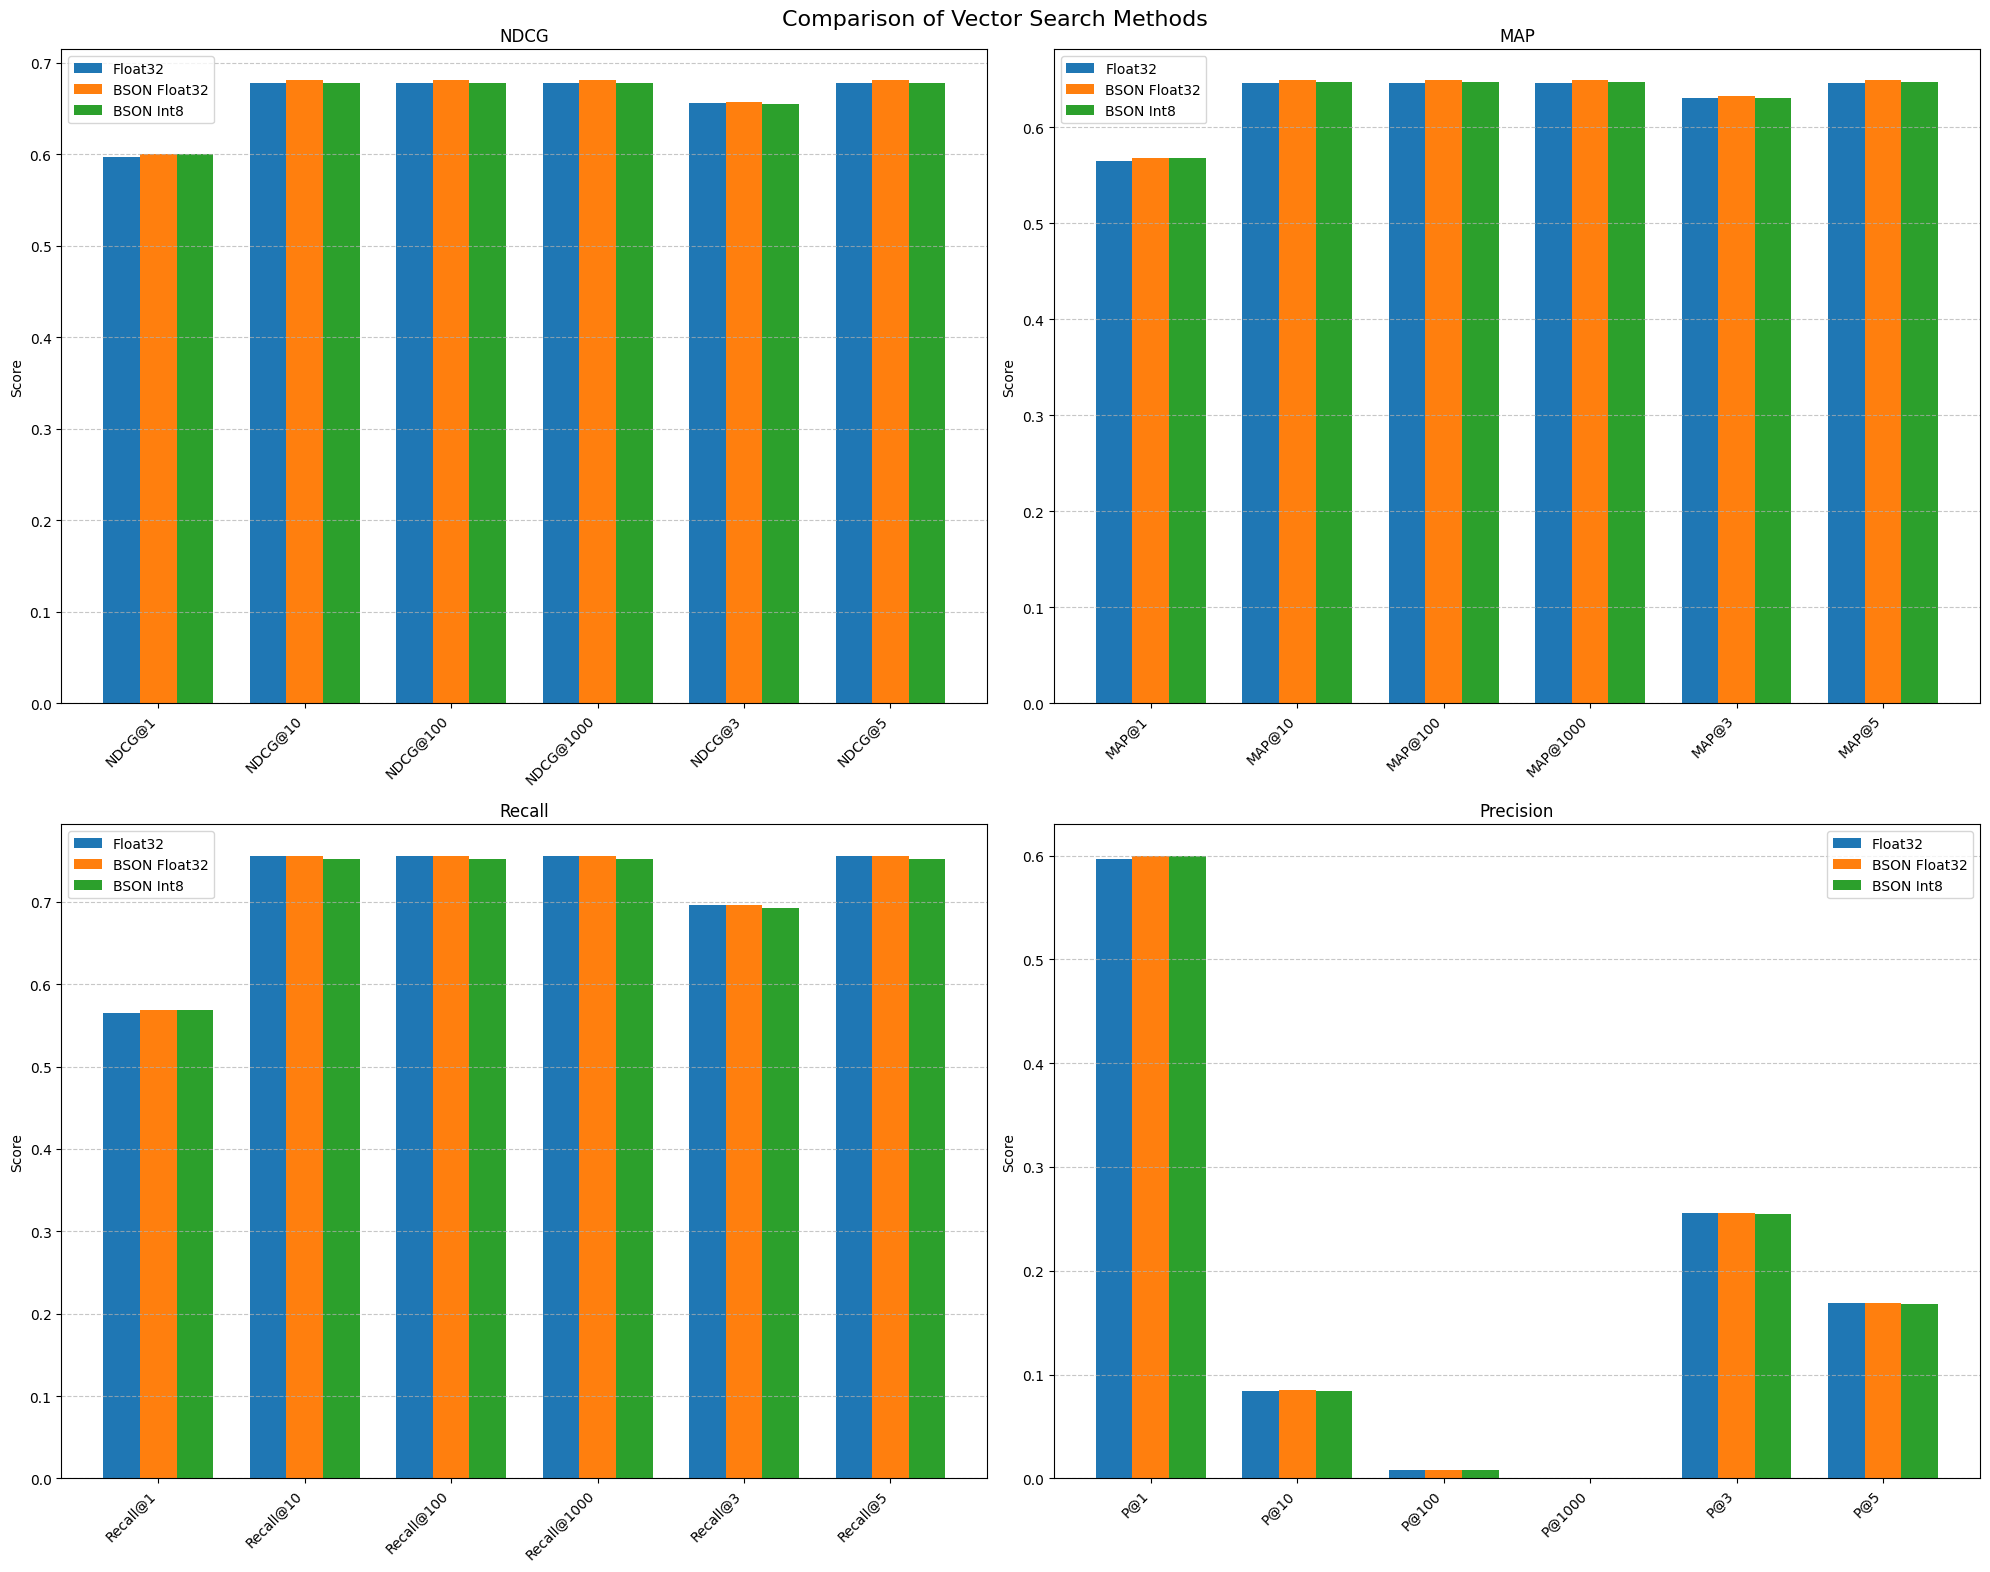

In [159]:
plot_search_method_comparison([
    float32_search_metric_dicts,
    bsonfloat32_search_metric_dicts,
    bsonint8_search_metric_dicts
])

In [ ]:

# 10. Visualisation of perforomance
# 11. Conclusion